![Judge Research](images/judgeresearch.png)
# Feature Data Tutorial

## Setup
Import modules for Judge Research, Coinalytix, technical analysis, and plotting tools.

In [12]:
# import classes that handle API connections and parameters
from historical_data import Coinalytix, HDParams
from judgeresearch import JudgeResearch, JRParams

# import classes for data handling & visiualization
import json
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import pandas_ta as ta
from watchlist import colors

## Authenticate
Enter your API keys here:

In [13]:
CA_API_KEY = "<paste your coinalytix.io key here>"
JR_API_KEY = "hHV1QUTclB653YLvFJBJh5Pz0BayF251at64c9x9"

## Configure Assets
Define the parameters for your historical data:

In [14]:
asset = HDParams()
# Set exchange, must be "BINANCE" or ...
asset.exchange = "BINANCE"
# Set asset, currently supports "BTC-USD-SPOT", "ETH-USD-SPOT", ...
asset.ticker = "BTC-USD-SPOT"
# Set start of reporting period in form YYYY-MM-DD HH:MM:SS
# Dates after 2019...? supported
asset.set_start_date("2022-01-01 08:00:00")
# Set reporting interval, currently supports "1d", "1m"...
asset.interval = "1d"
# Set number of reporting periods                    
asset.num_periods = 365

## Collect Data
Setup authentication and fetch historical data from Coinalytix

In [15]:
HD = Coinalytix()
# Set api key
HD.with_api_key(CA_API_KEY)
# Fetch historical data
asset_data = HD.fetch_hd(asset)
# Create Pandas data frame from result
hddf = pd.DataFrame.from_dict(asset_data)
# Adjust DatetimeIndex.
hddf.set_index(pd.DatetimeIndex(hddf["StartDate"]*1000000000), inplace=True)
# Print 5 sample lines
hddf.tail(5)

,StartDate,Open,High,Low,Close
StartDate,,,,,
2022-04-28,1.651104e+09,39235.7,40343.7,38883.4,39754.6
2022-04-29,1.651190e+09,39742.1,39925.2,38178.9,38587.9
2022-04-30,1.651277e+09,38596.1,38772.6,37604.7,37649.4
2022-05-01,1.651363e+09,37630.8,38662.3,37508.3,38465.5
2022-05-02,1.651450e+09,38468.4,39103.9,38324.0,38675.5


## Create a Feature Generation Function

In [23]:
# The feature_gen function accepts a pandas dataframe, datetime indexed and should return a pandas dataframe, similarly
# datetime index and including a column named "feature"

macddf = hddf.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)

def feature_gen(df):
    ''' Set feature column to 1 or 0 as MACD crosses MACDs '''
    df["macdiff"] = df["MACD_8_21_9"] - df["MACDs_8_21_9"]
    df["feature"] = ['0' if x > 0 else '1' for x in df['macdiff']]
    return df


## Research & Chart
Analyze and chart your dependent and indepenent variables

In [17]:
def ctitle(indicator_name, ticker="BTC-USD", length=100):
    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_enddate} ({length})"

def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

recent_startdate = hddf.tail(recent_bars(hddf)).index[0]
recent_enddate = hddf.tail(recent_bars(hddf)).index[-1]

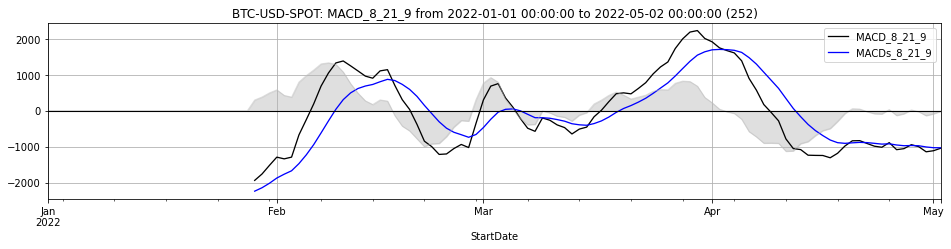

In [18]:
ind_size = (16, 3.25)
macddf[[macddf.columns[0], macddf.columns[2]]].tail(recent_bars(macddf)).plot(figsize=(16, 2), color=colors("BkBl"), linewidth=1.3)
macddf[macddf.columns[1]].tail(recent_bars(macddf)).plot.area(figsize=ind_size, stacked=False, color=["silver"], linewidth=1, title=ctitle(macddf.name, ticker=asset.ticker, length=recent_bars(macddf)), grid=True).axhline(y=0, color="black", lw=1.1)

## Configure Feature Parameters
Set the constants & default values below as appropriate.

In [19]:
# ATTRIBUTE - a string representing the time block of the observation,
# in coordinated universal time following the ISO 8601 standard, in UTC.
# The attribute should be structured as "YYYY-MM-DDTHH:MM:SSZ". For
# the alpha test, if you mistakenly send in objects with a date prior to
# "2019-01-01T00:00:00Z", you won’t receive an error message but earlier observations will be discarded.
JRATTRIBUTE = "2022-01-01T00:00:00Z" # default value

# DV - a string specifying the dependent variable. Choices during the alpha test are "ETH-USD", 
# "BTC-USD", and "V-BTC-USD", which denotes the volatility of BTC-USD.
JRDV = "ETH-USD"

# MBS - a string specifying the block size of the observation, in minutes. 
# This can be any positive number. For the alpha test, we are currently set to test four hour series,
# so 240 should be the value you set. We will likely include another time frame for the alpha test, 
# and will update this document when we do.
JRMBS= "240"

# FEATURE_NAME - an alphanumeric string for the name of the feature, of length no more than 50 characters. 
# You can name the feature whatever you want.
JRFEATURE_NAME = "testfeature001"

# VALUE - the most important part! A string with the value of the feature, also of length no more than 50 characters.
# The default value is set here, the feature_gen function will set this variable when generating new feature data.
JRVALUE = "0"    # default value

# IPP - optional, defaults to "last" - what type of interpolation procedure is appropriate for your feature. 
# Values can be either "last" - fill in the missing value with the last observed value - and "zero" - fill in 
# the last value with a 0.
JRIPP = "last"    # default value

## Connect to Judge Research 
## & Generate Feature Dataframe

In [20]:
# Connect to Judge Research with API key, craft payload, and submit feature data
JR = JudgeResearch()
# Configure API key
JR.with_api_key(JR_API_KEY)
# Generate feature dataframe
fdf = feature_gen(macddf)

## Create Dataframe 
## w/ Features & Metadata

In [21]:
# iterate through dataframe and create an instance of JRParams for each feature datapoint
def craft_features(df):
    _features = []
    for index, row in df.iterrows():
        _jrparams = JRParams()
        _jrparams.attribute = index.strftime('%Y-%m-%dT%H:%M:%SZ')
        _jrparams.dv = JRDV
        _jrparams.mbs = JRMBS
        _jrparams.feature_name = JRFEATURE_NAME
        _jrparams.value = row["feature"]
        _jrparams.ipp = JRIPP
        _features.append(_jrparams)
    return _features
features = craft_features(fdf)
# Craft payload
payload = JR.format_payload(features)

## Submit Feature Data

In [22]:
  # Submit feature data & print result
s = JR.submit_feature(payload)
print(s)

<Response [200]>


## Scheduling and Headless Execution
The feature_gen function can be run periodically from this notebook or exported for use in a self-contained docker runtime environment.  Running the feature generation locally, in this notebook, is appropriate for reasearch and testing; however, the notebook UI adds a layer of complexity which may be undesirable in production.

### Scheduling inside this notebook
instuctions here for python cron stuff...

### Scheduling a headless docker runtime 
instuctions for running the feature_gen code in a self-sufficient docker container..